# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク2

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

## 1.このSprintについて

### Sprintの目的
スクラッチを通してCNNの基礎を理解する

### どのように学ぶか
スクラッチで2次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。

## 2.2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。

### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。

今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。

`(n_samples, n_channels, height, width)`の`NCHW`または`(n_samples, height, width, n_channels)`の`NHWC`どちらかの形にしてください。

### 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

フォワードプロパゲーションの数式は以下のようになります。
$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値

$i$ : 配列の行方向のインデックス

$j$ : 配列の列方向のインデックス

$m$ : 出力チャンネルのインデックス

$K$ : 入力チャンネル数

$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ

$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値

$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み

$b_m$ : mチャンネルへの出力のバイアス項

全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。
$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$
$\alpha$ : 学習率

$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配

勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。
$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値

$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ

前の層に流す誤差の数式は以下です。
$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値

$M$ : 出力チャンネル数

ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

### 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。
$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$
$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

$h$ が高さ方向、 $w$ が幅方向である

In [2]:
def calc_output_nums(input_nums, pad_nums, filter_sizes, stride_sizes):
    output_nums_h = (input_nums[0] + 2*pad_nums[0]- filter_sizes[0]) // stride_sizes[0] + 1
    output_nums_w = (input_nums[1] + 2*pad_nums[1] - filter_sizes[1]) // stride_sizes[1] + 1
    return output_nums_h, output_nums_w

#### class Conv2d

In [3]:
class Conv2d:
    """
    チャンネル数を限定しない2次元畳み込み層
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    input_channels : int
      入力のチャンネル数
    output_channels : int
      出力のチャンネル数
    filter _sizes : tuple
      フィルタのサイズ (F_h, F_w)
    stride_sizes : tuple
      スライドのサイズ (S_h, S_w)
    padding : str or int
      パディングの指示
    pad_nums : tuple
      ある方向へのパディングする数(P_h, P_w)
    """
    
    def __init__(self, input_channels, output_channels, filter_sizes, stride_sizes, padding, initializer, optimizer, act_instance=None):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.filter_sizes = filter_sizes
        self.stride_sizes = stride_sizes
        self.padding = padding
        self.pad_nums = None #　paddingが呼び出されると計算される
        self.optimizer = optimizer
        # 活性化関数のインスタンス
        self.act_instance = act_instance
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(self.output_channels, self.input_channels, *self.filter_sizes)
        self.B = initializer.B(self.output_channels)
        
        # optimizerがAdagradの時に使う
        self.H_W = np.ones((self.output_channels, self.input_channels, *self.filter_sizes))
        self.H_B = np.ones(output_channels)
        
        
    def padding_nums(self, input_nums):
        if self.padding == 'SAME':
            pad_nums_h = int(np.ceil((self.stride_sizes[0] * (input_nums[0]-1) - input_nums[0] + self.filter_sizes[0]) / 2))
            pad_nums_w = int(np.ceil((self.stride_sizes[1] * (input_nums[1]-1) - input_nums[1] + self.filter_sizes[1]) / 2))
        elif self.padding == 'VALID':
            pad_nums_h, pad_nums_w = 0, 0
        else:
            pad_nums_h, pad_nums_w = self.padding
        return pad_nums_h, pad_nums_w

    def zero_padding_2d(self, X):
        input_nums = X.shape[-2:]
        self.pad_nums = self.padding_nums(input_nums)
        
        pad_width = [(0, 0) for _ in range(X.ndim-2)] + [(self.pad_nums[0], self.pad_nums[0])] + [(self.pad_nums[1], self.pad_nums[1])]
        return np.pad(X, pad_width, 'constant')
    
    def calc_output_nums(self, input_nums, pad_nums, filter_sizes, stride_sizes):
        output_nums_h = (input_nums[0] + 2*pad_nums[0]- filter_sizes[0]) // stride_sizes[0] + 1
        output_nums_w = (input_nums[1] + 2*pad_nums[1] - filter_sizes[1]) // stride_sizes[1] + 1
        return output_nums_h, output_nums_w
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, input_channels, Nh_in, Nw_in)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, output_channels, output_nums)
            出力
        """
        self.X = X
        self.batch_size, _, *self.input_nums = X.shape

        # パディングの処理、Xにゼロを追加する
        self.X = self.zero_padding_2d(X)
        
        # 出力する特徴量数を計算
        Nh_out, Nw_out = self.calc_output_nums(self.input_nums, self.pad_nums, self.filter_sizes, self.stride_sizes)
        
        # 畳み込みで計算するインデックスを計算
        h_indexes = np.array([[i for i in range(j * self.stride_sizes[0], self.filter_sizes[0]+(j * self.stride_sizes[0]))] for j in range(Nh_out)])
        w_indexes = np.array([[i for i in range(j * self.stride_sizes[1], self.filter_sizes[1]+(j * self.stride_sizes[1]))] for j in range(Nw_out)])        
        
        # 畳み込みを実施
        calc = np.tensordot(self.X[..., h_indexes, :][..., w_indexes], self.W, axes=([1, 3, 5], [1, 2, 3]))
        A = calc.transpose(0, 3, 1, 2) + self.B.reshape(1, -1, 1, 1)
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (self.output_channels, Nh_out, Nw_out)
            後ろから流れてきた勾配
        self.X : 次の形のndarray, shape (batch_size, self.input_channles, Nh_in, Nw_in)
            入力データ
        Returns
        ----------
        dX : 次の形のndarray, shape (batch_size, self.input_channles, Nh_in, Nw_in)
            前に流す勾配
        """
        # print('バックプロパゲーション ')
        Nh_out, Nw_out = dA.shape[-2:]
        
        calc = np.tensordot(dA, self.W, axes=([1], [0]))
        
        # ゼロのdXの箱を作る
        dX = np.zeros((self.batch_size, self.input_channels, 
                       max(self.filter_sizes[0]+Nh_out-1, self.input_nums[0]),
                       max(self.filter_sizes[1]+Nw_out-1, self.input_nums[1])))
        
        for i in range(Nh_out):
            for j in range(Nw_out):
                dX[..., i:i+self.filter_sizes[0], j:j+self.filter_sizes[1]] += calc[:, i, j]
                
        # inputのサイズに合わせる
        dX = dX[..., 0:self.input_nums[0], 0:self.input_nums[1]]
        
        # 更新
        self = self.optimizer.update_Conv2d(self, dA)
        return dX

#### class Initializer

In [4]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
    def W(self, *parameters):
        """
        重みの初期化
        Parameters
        ----------
        Conv2d
            output_channels : int 出力チャネル数
            input_channels : int 入力チャネル数
            filter_sizes : tuple フィルター数
                filter_sizes_h, filter_sizes_w
        Conv1d
            output_channels : int 出力チャネル数
            input_channels : int 入力チャネル数
            filter_sizes : int フィルター数
        Affine
            n_nodes1 : int 前の層のノード数
            n_nodes2 : int 後の層のノード数
        Returns
        ----------
        W : shape(*parameters)
        """
        W = self.sigma * np.random.randn(*parameters)
        return W
    def B(self, output_channels):
        """
        バイアスの初期化
        Parameters
        ----------
        Conv2d
            output_channels : int 出力チャネル数
        Conv1d
            output_channels : int 出力チャネル数
        Affine
            n_node2 : int 後の層のノード数
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(output_channels)
        return B

In [5]:
class XavierInitializer:
    """
    Xavierによる初期化
    Parameters
    ----------
    前の層のノード数の逆数の平方根を標準偏差とする分布
    """
    def W(self, *parameters):
        """
        重みの初期化
        Parameters
        ----------
        Conv2d
            output_channels : int 出力チャネル数
            input_channels : int 入力チャネル数
            filter_sizes : tuple フィルター数
                filter_sizes_h, filter_sizes_w
        Conv1d
            output_channels : int 出力チャネル数
            input_channels : int 入力チャネル数
            filter_sizes : int フィルター数
        Affine
            n_nodes1 : int 前の層のノード数
            n_nodes2 : int 後の層のノード数
        Returns
        ----------
        W : shape(*parameters)
        """
        if len(parameters) == 2:
            sigma = np.sqrt(1 / parameters[0])
        else:
            sigma = np.sqrt(1 / parameters[1])
        W = sigma * np.random.randn(*parameters)
        return W
        
    def B(self, output_channels):
        """
        バイアスの初期化
        Parameters
        ----------
        Conv2d
            output_channels : int 出力チャネル数
        Conv1d
            output_channels : int 出力チャネル数
        Affine
            n_node2 : int 後の層のノード数
        Returns
        ----------
        B :
        """
        B = np.zeros(output_channels)
        return B

In [6]:
class HeInitializer:
    """
    Heによる初期化
    Parameters
    ----------
    前の層のノード数の逆数を２倍した平方根を標準偏差とする分布
    """
    def W(self, *parameters):
        """
        重みの初期化
        Parameters
        ----------
        Conv2d
            output_channels : int 出力チャネル数
            input_channels : int 入力チャネル数
            filter_sizes : tuple フィルター数
                filter_sizes_h, filter_sizes_w
        Conv1d
            output_channels : int 出力チャネル数
            input_channels : int 入力チャネル数
            filter_sizes : int フィルター数
        Affine
            n_nodes1 : int 前の層のノード数
            n_nodes2 : int 後の層のノード数
        Returns
        ----------
        W : shape(*parameters)
        """
        if len(parameters) == 2:
            sigma = np.sqrt(2 / parameters[0])
        else:
            sigma = np.sqrt(2 / parameters[1])
        W = sigma * np.random.randn(*parameters)
        return W
        
    def B(self, output_channels):
        """
        バイアスの初期化
        Parameters
        ----------
        Conv2d
            output_channels : int 出力チャネル数
        Conv1d
            output_channels : int 出力チャネル数
        Affine
            n_node2 : int 後の層のノード数
        Returns
        ----------
        B :
        """
        B = np.zeros(output_channels)
        return B

#### class Optimizer

In [7]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.001):
        self.lr = lr
    def update_Conv2d(self, layer, dA):
        """
        Conv2d層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 次の形のndarray, shape (batch_size, layer.output_channels, Nh_out, Nw_out)
            後ろから流れてきた勾配
        """
        # dAのbatch_size, N_outの軸に沿って合計する
        dB = dA.sum(axis=3).sum(axis=2).sum(axis=0)
        
        Nh_out, Nw_out = dA.shape[-2:]
        
        # インデックス取得
        h_indexes = np.array([[i for i in range(j, layer.stride_sizes[0] * Nh_out + j, layer.stride_sizes[0])] for j in range(layer.filter_sizes[0])])
        w_indexes = np.array([[i for i in range(j, layer.stride_sizes[1] * Nw_out + j, layer.stride_sizes[1])] for j in range(layer.filter_sizes[1])])
        
        extract_X = layer.X[..., h_indexes, :][..., w_indexes]
        dW = np.tensordot(dA, extract_X, axes=([0, 2, 3], [0, 3, 5]))

        # バイアス、重みの更新
        layer.B = layer.B - dB * self.lr
        layer.W = layer.W - dW * self.lr
        # print('dB: {}'.format(dB.shape))
        # print('dW: {}'.format(dW.shape))
        
    def update_Conv1d(self, layer, dA):
        """
        Conv1d層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 次の形のndarray, shape (self.batch_size, self.output_channels, output_nums)
            後ろから流れてきた勾配
        """
        # 各勾配の計算
        # dAのbatch_size, N_outの軸に沿って合計する
        axis = dA.ndim-1
        dB = dA.sum(axis=axis).sum(axis=0)
        
        output_nums = dA.shape[-1]
        
        # 計算するためのインデックスを取得
        indexes = np.array([[i for i in range(j, layer.stride_sizes * output_nums + j, layer.stride_sizes)] for j in range(layer.filter_sizes)])        
        
        # dW　の計算
        dW = np.tensordot(dA, layer.X[..., indexes], axes=([0, 2], [0, 3]))
        
        # バイアス、重みの更新
        layer.B = layer.B - dB * self.lr
        layer.W = layer.W - dW * self.lr

    def update_FC(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 後ろから流れてきた勾配
        """
        # バイアスの更新
        dB = dA.sum(axis=0)
        layer.B -= dB * self.lr
        # 重みの更新
        dW = np.dot(layer.X.T, dA)
        layer.W -= dW * self.lr

In [8]:
class AdaGrad:
    """
    更新された分だけ、その重みに対する学習率を下げていく
    Parameters
    --------
    lr : 学習率
    """
    def __init__(self, lr=0.001):
        self.lr = lr
    
    def update_Conv2d(self, layer, dA):
        """
        Conv2d層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 次の形のndarray, shape (batch_size, layer.output_channels, Nh_out, Nw_out)
            後ろから流れてきた勾配
        """
        # dAのbatch_size, N_outの軸に沿って合計する
        dB = dA.sum(axis=3).sum(axis=2).sum(axis=0)
        layer.H_B += np.power(dB, 2)
        
        Nh_out, Nw_out = dA.shape[-2:]
        
        # インデックス取得
        h_indexes = np.array([[i for i in range(j, layer.stride_sizes[0] * Nh_out + j, layer.stride_sizes[0])] for j in range(layer.filter_sizes[0])])
        w_indexes = np.array([[i for i in range(j, layer.stride_sizes[1] * Nw_out + j, layer.stride_sizes[1])] for j in range(layer.filter_sizes[1])])
        
        extract_X = layer.X[..., h_indexes, :][..., w_indexes]
        dW = np.tensordot(dA, extract_X, axes=([0, 2, 3], [0, 3, 5]))
        layer.H_W += np.power(dW, 2)

        # バイアス、重みの更新
        layer.B = layer.B - dB * self.lr / np.sqrt(layer.H_B)
        layer.W = layer.W - dW * self.lr / np.sqrt(layer.H_W)
        # print('dB: {}'.format(dB.shape))
        # print('dW: {}'.format(dW.shape))
    
    def update_Conv1d(self, layer, dA):
        """
        Conv1d層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 次の形のndarray, shape (self.batch_size, self.output_channels, output_nums)
            後ろから流れてきた勾配
        X : 次の形のndarray, shape (self.batch_size, self.input_channles, input_nums)
            入力データ
        H_B, H_W : class_Conv1dで初期値1で作成
        """
        # 各勾配の計算
        # dAのbatch_size, N_outの軸に沿って合計する
        axis = dA.ndim-1
        dB = dA.sum(axis=axis).sum(axis=0)
        layer.H_B += np.power(dB, 2)
        
        output_nums = dA.shape[-1]
        
        # 計算するためのインデックスを取得
        indexes = np.array([[i for i in range(j, layer.stride_sizes * output_nums + j, layer.stride_sizes)] for j in range(layer.filter_sizes)])        
        
        # dW　の計算
        dW = np.tensordot(dA, layer.X[..., indexes], axes=([0, 2], [0, 3]))
        layer.H_W += np.power(dW, 2)
        
        # バイアス、重みの更新
        layer.B = layer.B - dB * self.lr / np.sqrt(layer.H_B)
        layer.W = layer.W - dW * self.lr / np.sqrt(layer.H_W)

    def update_FC(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 後ろから流れてきた勾配
        H_B, H_W : class_FCで初期値1で作成
        """
        # バイアスの更新
        dB = dA.sum(axis=0)
        layer.H_B += np.power(dB, 2)
        layer.B -= dB * self.lr / np.sqrt(layer.H_B)
        
        # 重みの更新
        dW = np.dot(layer.X.T, dA)
        layer.H_W += np.power(dW, 2)
        layer.W -= dW * self.lr / np.sqrt(layer.H_W)

- 試しに計算していくための初期値を設定

In [9]:
input_channels = 1
output_channels = 2
filter_sizes = (2, 2)
stride_sizes = (1, 1)
padding = (0, 0)
initializer = SimpleInitializer()
optimizer = SGD()
conv2d = Conv2d(input_channels, output_channels, filter_sizes, stride_sizes, padding, initializer, optimizer)

In [10]:
batch_size = 2
input_nums_h = 5
input_nums_w = 5

In [11]:
parameters = batch_size, input_channels, input_nums_h, input_nums_w
eX = np.arange(np.prod(parameters)).reshape(*parameters)
eX, eX.shape

(array([[[[ 0,  1,  2,  3,  4],
          [ 5,  6,  7,  8,  9],
          [10, 11, 12, 13, 14],
          [15, 16, 17, 18, 19],
          [20, 21, 22, 23, 24]]],
 
 
        [[[25, 26, 27, 28, 29],
          [30, 31, 32, 33, 34],
          [35, 36, 37, 38, 39],
          [40, 41, 42, 43, 44],
          [45, 46, 47, 48, 49]]]]),
 (2, 1, 5, 5))

- 初期化した重みの確認

In [12]:
conv2d.W, conv2d.W.shape

(array([[[[-0.0004071 ,  0.00256137],
          [-0.01091916, -0.01291126]]],
 
 
        [[[ 0.0021517 ,  0.00583977],
          [ 0.00606394, -0.01280037]]]]),
 (2, 1, 2, 2))

In [13]:
conv2d.B, conv2d.B.shape

(array([-0.00578355, -0.0004295 ]), (2,))

In [14]:
eW = np.array([[[2, 0], [0, -1]], [[-1, 2], [-1, 0]]]).reshape(output_channels, input_channels, *filter_sizes)
eW, eW.shape

(array([[[[ 2,  0],
          [ 0, -1]]],
 
 
        [[[-1,  2],
          [-1,  0]]]]),
 (2, 1, 2, 2))

##### フォワードプロパゲーション

- 入力特徴量数の取得

In [15]:
input_nums = eX.shape[-2:]
input_nums

(5, 5)

- パディングの処理

In [16]:
def padding_nums(input_nums):
    if padding == 'SAME':
        pad_nums_h = int(np.ceil((stride_sizes[0] * (input_nums[0]-1) - input_nums[0] + filter_sizes[0]) / 2))
        pad_nums_w = int(np.ceil((stride_sizes[1] * (input_nums[1]-1) - input_nums[1] + filter_sizes[1]) / 2))
    elif padding == 'VALID':
        pad_nums_h, pad_nums_w = 0, 0
    else:
        pad_nums_h, pad_nums_w = padding
    return pad_nums_h, pad_nums_w

In [17]:
pad_nums = padding_nums(input_nums)
pad_nums

(0, 0)

In [18]:
def zero_padding_2d(X):
    pad_width = [(0, 0) for _ in range(X.ndim-2)] + [(pad_nums[0], pad_nums[0])] + [(pad_nums[1], pad_nums[1])]
    return np.pad(X, pad_width, 'constant')

In [19]:
local_eX = zero_padding_2d(eX)
local_eX, local_eX.shape

(array([[[[ 0,  1,  2,  3,  4],
          [ 5,  6,  7,  8,  9],
          [10, 11, 12, 13, 14],
          [15, 16, 17, 18, 19],
          [20, 21, 22, 23, 24]]],
 
 
        [[[25, 26, 27, 28, 29],
          [30, 31, 32, 33, 34],
          [35, 36, 37, 38, 39],
          [40, 41, 42, 43, 44],
          [45, 46, 47, 48, 49]]]]),
 (2, 1, 5, 5))

- 出力数の計算

In [20]:
Nh_out, Nw_out = calc_output_nums(input_nums=input_nums, pad_nums=pad_nums, filter_sizes=filter_sizes, stride_sizes=stride_sizes)
Nh_out, Nw_out

(4, 4)

- 畳み込み計算するインデックスの取得

In [21]:
h_indexes = np.array([[i for i in range(j * stride_sizes[0], filter_sizes[0]+(j * stride_sizes[0]))] for j in range(Nh_out)])
w_indexes = np.array([[i for i in range(j * stride_sizes[1], filter_sizes[1]+(j * stride_sizes[1]))] for j in range(Nw_out)])

In [22]:
h_indexes, h_indexes.shape #(output_nums_h, F_h)

(array([[0, 1],
        [1, 2],
        [2, 3],
        [3, 4]]),
 (4, 2))

In [23]:
w_indexes, w_indexes.shape #(output_nums_w, F_w)

(array([[0, 1],
        [1, 2],
        [2, 3],
        [3, 4]]),
 (4, 2))

- 軸に沿ってXにインデックスを代入
- 行方向で取りたい

In [24]:
local_eX[..., h_indexes, :], local_eX[..., h_indexes, :].shape

(array([[[[[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9]],
 
          [[ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14]],
 
          [[10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]],
 
          [[15, 16, 17, 18, 19],
           [20, 21, 22, 23, 24]]]],
 
 
 
        [[[[25, 26, 27, 28, 29],
           [30, 31, 32, 33, 34]],
 
          [[30, 31, 32, 33, 34],
           [35, 36, 37, 38, 39]],
 
          [[35, 36, 37, 38, 39],
           [40, 41, 42, 43, 44]],
 
          [[40, 41, 42, 43, 44],
           [45, 46, 47, 48, 49]]]]]),
 (2, 1, 4, 2, 5))

- 列方向で取りたい

In [25]:
local_eX[..., w_indexes], local_eX[..., w_indexes].shape

(array([[[[[ 0,  1],
           [ 1,  2],
           [ 2,  3],
           [ 3,  4]],
 
          [[ 5,  6],
           [ 6,  7],
           [ 7,  8],
           [ 8,  9]],
 
          [[10, 11],
           [11, 12],
           [12, 13],
           [13, 14]],
 
          [[15, 16],
           [16, 17],
           [17, 18],
           [18, 19]],
 
          [[20, 21],
           [21, 22],
           [22, 23],
           [23, 24]]]],
 
 
 
        [[[[25, 26],
           [26, 27],
           [27, 28],
           [28, 29]],
 
          [[30, 31],
           [31, 32],
           [32, 33],
           [33, 34]],
 
          [[35, 36],
           [36, 37],
           [37, 38],
           [38, 39]],
 
          [[40, 41],
           [41, 42],
           [42, 43],
           [43, 44]],
 
          [[45, 46],
           [46, 47],
           [47, 48],
           [48, 49]]]]]),
 (2, 1, 5, 4, 2))

- 行と列で合わせて代入

In [26]:
print(local_eX[..., h_indexes, :][..., w_indexes])
print(local_eX[..., h_indexes, :][..., w_indexes].shape)
print('(batch_size, input_channels, Nout_h, F_h, Nout_w, F_w)')

[[[[[[ 0  1]
     [ 1  2]
     [ 2  3]
     [ 3  4]]

    [[ 5  6]
     [ 6  7]
     [ 7  8]
     [ 8  9]]]


   [[[ 5  6]
     [ 6  7]
     [ 7  8]
     [ 8  9]]

    [[10 11]
     [11 12]
     [12 13]
     [13 14]]]


   [[[10 11]
     [11 12]
     [12 13]
     [13 14]]

    [[15 16]
     [16 17]
     [17 18]
     [18 19]]]


   [[[15 16]
     [16 17]
     [17 18]
     [18 19]]

    [[20 21]
     [21 22]
     [22 23]
     [23 24]]]]]




 [[[[[25 26]
     [26 27]
     [27 28]
     [28 29]]

    [[30 31]
     [31 32]
     [32 33]
     [33 34]]]


   [[[30 31]
     [31 32]
     [32 33]
     [33 34]]

    [[35 36]
     [36 37]
     [37 38]
     [38 39]]]


   [[[35 36]
     [36 37]
     [37 38]
     [38 39]]

    [[40 41]
     [41 42]
     [42 43]
     [43 44]]]


   [[[40 41]
     [41 42]
     [42 43]
     [43 44]]

    [[45 46]
     [46 47]
     [47 48]
     [48 49]]]]]]
(2, 1, 4, 2, 4, 2)
(batch_size, input_channels, Nout_h, F_h, Nout_w, F_w)


In [27]:
print(eW)
print(eW.shape)
print('(output_channels, input_channels, F_h, F_w)')

[[[[ 2  0]
   [ 0 -1]]]


 [[[-1  2]
   [-1  0]]]]
(2, 1, 2, 2)
(output_channels, input_channels, F_h, F_w)


- tensordotを行い、input_channels, F_h, F_wを消去

In [28]:
calc = np.tensordot(local_eX[..., h_indexes, :][..., w_indexes], eW, axes=([1, 3, 5], [1, 2, 3]))
print(calc)
print(calc.shape)
print('(batch_size, Nout_h, Nout_w, output_channels)')

[[[[-6 -3]
   [-5 -3]
   [-4 -3]
   [-3 -3]]

  [[-1 -3]
   [ 0 -3]
   [ 1 -3]
   [ 2 -3]]

  [[ 4 -3]
   [ 5 -3]
   [ 6 -3]
   [ 7 -3]]

  [[ 9 -3]
   [10 -3]
   [11 -3]
   [12 -3]]]


 [[[19 -3]
   [20 -3]
   [21 -3]
   [22 -3]]

  [[24 -3]
   [25 -3]
   [26 -3]
   [27 -3]]

  [[29 -3]
   [30 -3]
   [31 -3]
   [32 -3]]

  [[34 -3]
   [35 -3]
   [36 -3]
   [37 -3]]]]
(2, 4, 4, 2)
(batch_size, Nout_h, Nout_w, output_channels)


- 初期化した重みでローカルで計算したもの

In [29]:
calc = np.tensordot(local_eX[..., h_indexes, :][..., w_indexes], conv2d.W, axes=([1, 3, 5], [1, 2, 3]))
print(calc)
print(calc.shape)
print('(batch_size, Nout_h, Nout_w, output_channels)')

[[[[-1.29501998e-01 -4.06427555e-02]
   [-1.51178147e-01 -3.93877158e-02]
   [-1.72854296e-01 -3.81326761e-02]
   [-1.94530446e-01 -3.68776364e-02]]

  [[-2.37882744e-01 -3.43675570e-02]
   [-2.59558893e-01 -3.31125173e-02]
   [-2.81235043e-01 -3.18574775e-02]
   [-3.02911192e-01 -3.06024378e-02]]

  [[-3.46263491e-01 -2.80923584e-02]
   [-3.67939640e-01 -2.68373187e-02]
   [-3.89615789e-01 -2.55822790e-02]
   [-4.11291939e-01 -2.43272393e-02]]

  [[-4.54644237e-01 -2.18171598e-02]
   [-4.76320386e-01 -2.05621201e-02]
   [-4.97996536e-01 -1.93070804e-02]
   [-5.19672685e-01 -1.80520407e-02]]]


 [[[-6.71405730e-01 -9.26676268e-03]
   [-6.93081879e-01 -8.01172296e-03]
   [-7.14758029e-01 -6.75668325e-03]
   [-7.36434178e-01 -5.50164353e-03]]

  [[-7.79786477e-01 -2.99156411e-03]
   [-8.01462626e-01 -1.73652439e-03]
   [-8.23138775e-01 -4.81484676e-04]
   [-8.44814925e-01  7.73555038e-04]]

  [[-8.88167223e-01  3.28363447e-03]
   [-9.09843372e-01  4.53867418e-03]
   [-9.31519522e-01  5.7

- output_channelsの位置を変更するために転置をして、バイアスを足す

In [30]:
A = calc.transpose(0, 3, 1, 2) + conv2d.B.reshape(1, -1, 1, 1)
print(A)
print(A.shape)
print('(batch_size, output_channels, Nout_h, Nout_w)')

[[[[-1.35285549e-01 -1.56961698e-01 -1.78637848e-01 -2.00313997e-01]
   [-2.43666296e-01 -2.65342445e-01 -2.87018594e-01 -3.08694744e-01]
   [-3.52047042e-01 -3.73723191e-01 -3.95399341e-01 -4.17075490e-01]
   [-4.60427789e-01 -4.82103938e-01 -5.03780087e-01 -5.25456237e-01]]

  [[-4.10722540e-02 -3.98172143e-02 -3.85621745e-02 -3.73071348e-02]
   [-3.47970554e-02 -3.35420157e-02 -3.22869760e-02 -3.10319362e-02]
   [-2.85218568e-02 -2.72668171e-02 -2.60117774e-02 -2.47567377e-02]
   [-2.22466582e-02 -2.09916185e-02 -1.97365788e-02 -1.84815391e-02]]]


 [[[-6.77189282e-01 -6.98865431e-01 -7.20541580e-01 -7.42217730e-01]
   [-7.85570028e-01 -8.07246177e-01 -8.28922327e-01 -8.50598476e-01]
   [-8.93950775e-01 -9.15626924e-01 -9.37303073e-01 -9.58979223e-01]
   [-1.00233152e+00 -1.02400767e+00 -1.04568382e+00 -1.06735997e+00]]

  [[-9.69626110e-03 -8.44122139e-03 -7.18618167e-03 -5.93114196e-03]
   [-3.42106253e-03 -2.16602281e-03 -9.10983100e-04  3.44056614e-04]
   [ 2.85413604e-03  4.109

- クラスに反映させクラス内で計算

In [31]:
conv2d.forward(eX).shape

(2, 2, 4, 4)

##### バックプロパゲーション

- dAはとりあえず上記で計算したものを使う

In [32]:
dA = np.tensordot(local_eX[..., h_indexes, :][..., w_indexes], eW, axes=([1, 3, 5], [1, 2, 3])).transpose(0, 3, 1, 2)
print(dA)
print(dA.shape)
print('(batch_size, output_channels, Nh_out, Nw_out)')

[[[[-6 -5 -4 -3]
   [-1  0  1  2]
   [ 4  5  6  7]
   [ 9 10 11 12]]

  [[-3 -3 -3 -3]
   [-3 -3 -3 -3]
   [-3 -3 -3 -3]
   [-3 -3 -3 -3]]]


 [[[19 20 21 22]
   [24 25 26 27]
   [29 30 31 32]
   [34 35 36 37]]

  [[-3 -3 -3 -3]
   [-3 -3 -3 -3]
   [-3 -3 -3 -3]
   [-3 -3 -3 -3]]]]
(2, 2, 4, 4)
(batch_size, output_channels, Nh_out, Nw_out)


- dBを計算

$$
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値

$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ

In [33]:
# dAのbatch_size, Nout_h, Nout_wの軸に沿って合計する
dB = dA.sum(axis=3).sum(axis=2).sum(axis=0)
print(dB)
print(dB.shape)
print('(output_channels, )')

[496 -96]
(2,)
(output_channels, )


- dWを計算

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値

$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ

- インデックスを取得してXを抽出

In [34]:
h_indexes = np.array([[i for i in range(j, stride_sizes[0] * Nh_out + j, stride_sizes[0])] for j in range(filter_sizes[0])])
w_indexes = np.array([[i for i in range(j, stride_sizes[1] * Nw_out + j, stride_sizes[1])] for j in range(filter_sizes[1])])
h_indexes, w_indexes

(array([[0, 1, 2, 3],
        [1, 2, 3, 4]]),
 array([[0, 1, 2, 3],
        [1, 2, 3, 4]]))

In [35]:
extract_X = local_eX[..., h_indexes, :][..., w_indexes]
print(extract_X)
print(extract_X.shape)
print('(batch_size, input_channels, F_h, Nh_out, F_w, Nw_out)')

[[[[[[ 0  1  2  3]
     [ 1  2  3  4]]

    [[ 5  6  7  8]
     [ 6  7  8  9]]

    [[10 11 12 13]
     [11 12 13 14]]

    [[15 16 17 18]
     [16 17 18 19]]]


   [[[ 5  6  7  8]
     [ 6  7  8  9]]

    [[10 11 12 13]
     [11 12 13 14]]

    [[15 16 17 18]
     [16 17 18 19]]

    [[20 21 22 23]
     [21 22 23 24]]]]]




 [[[[[25 26 27 28]
     [26 27 28 29]]

    [[30 31 32 33]
     [31 32 33 34]]

    [[35 36 37 38]
     [36 37 38 39]]

    [[40 41 42 43]
     [41 42 43 44]]]


   [[[30 31 32 33]
     [31 32 33 34]]

    [[35 36 37 38]
     [36 37 38 39]]

    [[40 41 42 43]
     [41 42 43 44]]

    [[45 46 47 48]
     [46 47 48 49]]]]]]
(2, 1, 2, 4, 2, 4)
(batch_size, input_channels, F_h, Nh_out, F_w, Nw_out)


- tensordotを行い、batch_size, Nh_out, Nw_outを消去してdWを計算

In [36]:
dW = np.tensordot(dA, extract_X, axes=([0, 2, 3], [0, 3, 5]))
print(dW)
print(dW.shape)
print('(output_channels, input_channels, F_h, F_w)')

[[[[16704 17200]
   [19184 19680]]]


 [[[-2064 -2160]
   [-2544 -2640]]]]
(2, 1, 2, 2)
(output_channels, input_channels, F_h, F_w)


- dXを計算

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$
$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値

$M$ : 出力チャンネル数

ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

In [37]:
print(dA.shape)
print('(batch_size, output_channels, Nh_out, Nw_out)')

(2, 2, 4, 4)
(batch_size, output_channels, Nh_out, Nw_out)


In [38]:
print(eW.shape)
print('(output_channels, input_channels, F_h, F_w)')

(2, 1, 2, 2)
(output_channels, input_channels, F_h, F_w)


- tensordotを行い、output_channelsを消去

In [39]:
calc = np.tensordot(dA, eW, axes=([1], [0]))
print(calc)
print(calc.shape)
print('(batch_size, Nh_out, Nw_out, input_channels, F_h, F_w)')

[[[[[[ -9  -6]
     [  3   6]]]


   [[[ -7  -6]
     [  3   5]]]


   [[[ -5  -6]
     [  3   4]]]


   [[[ -3  -6]
     [  3   3]]]]



  [[[[  1  -6]
     [  3   1]]]


   [[[  3  -6]
     [  3   0]]]


   [[[  5  -6]
     [  3  -1]]]


   [[[  7  -6]
     [  3  -2]]]]



  [[[[ 11  -6]
     [  3  -4]]]


   [[[ 13  -6]
     [  3  -5]]]


   [[[ 15  -6]
     [  3  -6]]]


   [[[ 17  -6]
     [  3  -7]]]]



  [[[[ 21  -6]
     [  3  -9]]]


   [[[ 23  -6]
     [  3 -10]]]


   [[[ 25  -6]
     [  3 -11]]]


   [[[ 27  -6]
     [  3 -12]]]]]




 [[[[[ 41  -6]
     [  3 -19]]]


   [[[ 43  -6]
     [  3 -20]]]


   [[[ 45  -6]
     [  3 -21]]]


   [[[ 47  -6]
     [  3 -22]]]]



  [[[[ 51  -6]
     [  3 -24]]]


   [[[ 53  -6]
     [  3 -25]]]


   [[[ 55  -6]
     [  3 -26]]]


   [[[ 57  -6]
     [  3 -27]]]]



  [[[[ 61  -6]
     [  3 -29]]]


   [[[ 63  -6]
     [  3 -30]]]


   [[[ 65  -6]
     [  3 -31]]]


   [[[ 67  -6]
     [  3 -32]]]]



  [[[[ 71  -6]
     [  3 -34]]]


- Nh_out, Nw_outにそって順番に取り出し足していく

In [40]:
# からのdXの箱を作る
dX = np.zeros((batch_size, input_channels, filter_sizes[0]+Nh_out-1, filter_sizes[1]+Nw_out-1))
dX.shape

(2, 1, 5, 5)

In [41]:
for i in range(Nh_out):
    for j in range(Nw_out):
        dX[..., i:i+filter_sizes[0], j:j+filter_sizes[1]] += calc[:, i, j]
print(dX)
print(dX.shape)

[[[[ -9. -13. -11.  -9.  -6.]
   [  4.   6.   7.   8.  -3.]
   [ 14.  11.  12.  13.  -8.]
   [ 24.  16.  17.  18. -13.]
   [  3.  -6.  -7.  -8. -12.]]]


 [[[ 41.  37.  39.  41.  -6.]
   [ 54.  31.  32.  33. -28.]
   [ 64.  36.  37.  38. -33.]
   [ 74.  41.  42.  43. -38.]
   [  3. -31. -32. -33. -37.]]]]
(2, 1, 5, 5)


- 最後に入力時のサイズに合わせる

In [42]:
# inputのサイズに合わせる
dX = dX[..., :input_nums[0], :input_nums[1]]
print(dX)
print(dX.shape)

[[[[ -9. -13. -11.  -9.  -6.]
   [  4.   6.   7.   8.  -3.]
   [ 14.  11.  12.  13.  -8.]
   [ 24.  16.  17.  18. -13.]
   [  3.  -6.  -7.  -8. -12.]]]


 [[[ 41.  37.  39.  41.  -6.]
   [ 54.  31.  32.  33. -28.]
   [ 64.  36.  37.  38. -33.]
   [ 74.  41.  42.  43. -38.]
   [  3. -31. -32. -33. -37.]]]]
(2, 1, 5, 5)


In [43]:
conv2d.backward(dA).shape

(2, 1, 5, 5)

### 【問題3】最大プーリング層の作成

最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$
$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）

$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ

$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス

$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値

$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [44]:
np.random.seed(1)
x = np.random.choice(np.arange(100), 50, replace=False).reshape(2, 1, 5, 5)
x

array([[[[80, 84, 33, 81, 93],
         [17, 36, 82, 69, 65],
         [92, 39, 56, 52, 51],
         [32, 31, 44, 78, 10],
         [ 2, 73, 97, 62, 19]]],


       [[[35, 94, 27, 46, 38],
         [67, 99, 54, 95, 88],
         [40, 48, 59, 23, 34],
         [86, 53, 77, 15, 83],
         [41, 45, 91, 26, 98]]]])

##### フォワードプロパゲーション

In [45]:
pooling_sizes=(2, 3)
ph, pw = pooling_sizes

In [46]:
Nh_in, Nw_in = x.shape[-2:]
Nh_in, Nw_in

(5, 5)

- プーリング前処理

In [47]:
# 端で追加しないいけない数を計算
add_h = 0 if Nh_in % ph == 0 else ph - Nh_in % ph
add_w = 0 if Nw_in % pw == 0 else pw - Nw_in % pw

In [48]:
h_indexes = np.arange(Nh_in+add_h).reshape(-1, ph)
w_indexes = np.arange(Nw_in+add_w).reshape(-1, pw)
h_indexes, w_indexes

(array([[0, 1],
        [2, 3],
        [4, 5]]),
 array([[0, 1, 2],
        [3, 4, 5]]))

In [49]:
# マイナス無限大でパディング
pad_x = np.pad(x, pad_width=[(0, 0), (0, 0), (0, add_h), (0, add_w)], mode='constant', constant_values=-float('inf'))
pad_x

array([[[[                  80,                   84,
                            33,                   81,
                            93, -9223372036854775808],
         [                  17,                   36,
                            82,                   69,
                            65, -9223372036854775808],
         [                  92,                   39,
                            56,                   52,
                            51, -9223372036854775808],
         [                  32,                   31,
                            44,                   78,
                            10, -9223372036854775808],
         [                   2,                   73,
                            97,                   62,
                            19, -9223372036854775808],
         [-9223372036854775808, -9223372036854775808,
          -9223372036854775808, -9223372036854775808,
          -9223372036854775808, -9223372036854775808]]],


       [[[        

- インデックスをとって最大値でプーリング

In [50]:
pad_x[:, :, h_indexes][..., w_indexes].shape

(2, 1, 3, 2, 2, 3)

In [51]:
pool_x = pad_x[:, :, h_indexes][..., w_indexes].max(axis=5).max(axis=3)
pool_x, pool_x.shape

(array([[[[84, 93],
          [92, 78],
          [97, 62]]],
 
 
        [[[99, 95],
          [86, 83],
          [91, 98]]]]),
 (2, 1, 3, 2))

- プーリングした値を保ちながら、再度元のサイズに拡張

In [52]:
pool_x_back = np.repeat(np.repeat(pool_x, pw, axis=3), ph, axis=2)
pool_x_back

array([[[[84, 84, 84, 93, 93, 93],
         [84, 84, 84, 93, 93, 93],
         [92, 92, 92, 78, 78, 78],
         [92, 92, 92, 78, 78, 78],
         [97, 97, 97, 62, 62, 62],
         [97, 97, 97, 62, 62, 62]]],


       [[[99, 99, 99, 95, 95, 95],
         [99, 99, 99, 95, 95, 95],
         [86, 86, 86, 83, 83, 83],
         [86, 86, 86, 83, 83, 83],
         [91, 91, 91, 98, 98, 98],
         [91, 91, 91, 98, 98, 98]]]])

- プーリングする前の配列と、最大値が一致するセルを１で記録

In [53]:
back_indexes = np.where(pad_x == pool_x_back,1,0)
back_indexes

array([[[[0, 1, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0, 0]]],


       [[[0, 0, 0, 0, 0, 0],
         [0, 1, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1, 0],
         [0, 0, 1, 0, 1, 0],
         [0, 0, 0, 0, 0, 0]]]])

##### バックプロパゲーション

- 拡張した配列とアダマール積を取り、元の配列サイズを取得する

In [54]:
calc = pool_x_back * back_indexes
calc[..., :Nh_in, :Nw_in]

array([[[[ 0, 84,  0,  0, 93],
         [ 0,  0,  0,  0,  0],
         [92,  0,  0,  0,  0],
         [ 0,  0,  0, 78,  0],
         [ 0,  0, 97, 62,  0]]],


       [[[ 0,  0,  0,  0,  0],
         [ 0, 99,  0, 95,  0],
         [ 0,  0,  0,  0,  0],
         [86,  0,  0,  0, 83],
         [ 0,  0, 91,  0, 98]]]])

#### class MaxPool2d

In [55]:
class MaxPool2d:
    """
    2次元の最大プーリング層
    Parameters
    ----------
    pooling_sizes : tuple
      プーリングのサイズ (P_h, P_w)
    """
    
    def __init__(self, pooling_sizes):
        self.pooling_sizes = pooling_sizes
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, input_channels, Nh_in, Nw_in)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, input_channels, プーリング後のサイズ)
            出力
        """
        # print('フォワードプロパゲーション')
        # 入力からshapeを取得
        batch_size, input_channels, self.Nh_in, self.Nw_in = X.shape
        # プーリング前処理
        # 端で追加しないいけない数を計算
        add_h = 0 if self.Nh_in % self.pooling_sizes[0] == 0 else self.pooling_sizes[0] - self.Nh_in % self.pooling_sizes[0]
        add_w = 0 if self.Nw_in % self.pooling_sizes[1] == 0 else self.pooling_sizes[1] - self.Nw_in % self.pooling_sizes[1]
        # インデックスを取得
        h_indexes = np.arange(self.Nh_in+add_h).reshape(-1, self.pooling_sizes[0])
        w_indexes = np.arange(self.Nw_in+add_w).reshape(-1, self.pooling_sizes[1])
    
        # はみ出す部分をマイナス無限大でパディング
        self.X = np.pad(X, pad_width=[(0, 0), (0, 0), (0, add_h), (0, add_w)], mode='constant', constant_values=-float('inf'))
        # 最大値でプーリング
        pooling_X = self.X[:, :, h_indexes][..., w_indexes].max(axis=5).max(axis=3)
        # 最大値を保ち再度拡張
        pool_back = np.repeat(np.repeat(pooling_X, self.pooling_sizes[1], axis=3), self.pooling_sizes[0], axis=2)
        # プーリングする前（パディング後）の配列と一致する部分を記録
        self.back_indexes = np.where(self.X == pool_back,1,0)
        return pooling_X
        
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, input_channels, プーリング後のサイズ)
            後ろから流れてきた勾配
        self.X : 次の形のndarray, shape (batch_size, input_channels, Nh_in, Nw_in)
        Returns
        ----------
        dX : 次の形のndarray, shape (batch_size, input_channels, Nh_in, Nw_in)
            前に流す勾配
        """
        # print('バックプロパゲーション ')
        # 誤差を元のサイズに拡張
        resize_dA = np.repeat(np.repeat(dA, self.pooling_sizes[1], axis=3), self.pooling_sizes[0], axis=2)
        # プーリングした際に記録したインデックスをもとにアダマール積をとる
        back_pooling = resize_dA * self.back_indexes
        # 元のサイズに切り取り戻す
        back_pooling = back_pooling[..., :self.Nh_in, :self.Nw_in]
        return back_pooling

In [56]:
max_pooling = MaxPool2d(pooling_sizes=(2, 4))

In [57]:
A = max_pooling.forward(x)
A

array([[[[84, 93],
         [92, 51],
         [97, 19]]],


       [[[99, 88],
         [86, 83],
         [91, 98]]]])

In [58]:
dA = A
max_pooling.backward(dA)

array([[[[ 0, 84,  0,  0, 93],
         [ 0,  0,  0,  0,  0],
         [92,  0,  0,  0, 51],
         [ 0,  0,  0,  0,  0],
         [ 0,  0, 97,  0, 19]]],


       [[[ 0,  0,  0,  0,  0],
         [ 0, 99,  0,  0, 88],
         [ 0,  0,  0,  0,  0],
         [86,  0,  0,  0, 83],
         [ 0,  0, 91,  0, 98]]]])

### 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。

範囲内の最大値ではなく、平均値を出力とするプーリング層です。

画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

#### class AveragePool2d

In [59]:
class AveragePool2d:
    """
    2次元の平均プーリング層
    Parameters
    ----------
    pooling_sizes : tuple
      プーリングのサイズ (P_h, P_w)
    """
    
    def __init__(self, pooling_sizes):
        self.pooling_sizes = pooling_sizes
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, input_channels, Nh_in, Nw_in)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, input_channels, プーリング後のサイズ)
            出力
        """
        # print('フォワードプロパゲーション')
        # 入力からshapeを取得
        batch_size, input_channels, self.Nh_in, self.Nw_in = X.shape
        # プーリング前処理
        # 端で追加しないいけない数を計算
        add_h = 0 if self.Nh_in % self.pooling_sizes[0] == 0 else self.pooling_sizes[0] - self.Nh_in % self.pooling_sizes[0]
        add_w = 0 if self.Nw_in % self.pooling_sizes[1] == 0 else self.pooling_sizes[1] - self.Nw_in % self.pooling_sizes[1]
        # インデックスを取得
        h_indexes = np.arange(self.Nh_in+add_h).reshape(-1, self.pooling_sizes[0])
        w_indexes = np.arange(self.Nw_in+add_w).reshape(-1, self.pooling_sizes[1])
    
        # はみ出す部分を端の数値でパディング
        self.X = np.pad(X, pad_width=[(0, 0), (0, 0), (0, add_h), (0, add_w)], mode='edge')

        # 平均値でプーリング
        pooling_X = self.X[:, :, h_indexes][..., w_indexes].mean(axis=5).mean(axis=3)

#         # 最大値を保ち再度拡張
#         pool_back = np.repeat(np.repeat(pooling_X, self.pooling_sizes[1], axis=3), self.pooling_sizes[0], axis=2)
#         # プーリングする前（パディング後）の配列と一致する部分を記録
#         self.back_indexes = np.where(self.X == pool_back,1,0)
        return pooling_X
        
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, input_channels, プーリング後のサイズ)
            後ろから流れてきた勾配
        self.X : 次の形のndarray, shape (batch_size, input_channels, Nh_in, Nw_in)
        Returns
        ----------
        dX : 次の形のndarray, shape (batch_size, input_channels, Nh_in, Nw_in)
            前に流す勾配
        """
        # print('バックプロパゲーション ')
        # 誤差を元のサイズに拡張
        resize_dA = np.repeat(np.repeat(dA, self.pooling_sizes[1], axis=3), self.pooling_sizes[0], axis=2)
        # プーリングサイズで割る
        back_pooling = resize_dA / self.pooling_sizes[0] / self.pooling_sizes[1]
        # 元のサイズに切り取り戻す
        back_pooling = back_pooling[..., :self.Nh_in, :self.Nw_in]
        return back_pooling

In [60]:
average_pooling = AveragePool2d(pooling_sizes=(2,3))
A = average_pooling.forward(x)
A

array([[[[55.33333333, 77.66666667],
         [49.        , 42.        ],
         [57.33333333, 33.33333333]]],


       [[[62.66666667, 65.5       ],
         [60.5       , 45.33333333],
         [59.        , 74.        ]]]])

In [61]:
dA = A
average_pooling.backward(dA)

array([[[[ 9.22222222,  9.22222222,  9.22222222, 12.94444444,
          12.94444444],
         [ 9.22222222,  9.22222222,  9.22222222, 12.94444444,
          12.94444444],
         [ 8.16666667,  8.16666667,  8.16666667,  7.        ,
           7.        ],
         [ 8.16666667,  8.16666667,  8.16666667,  7.        ,
           7.        ],
         [ 9.55555556,  9.55555556,  9.55555556,  5.55555556,
           5.55555556]]],


       [[[10.44444444, 10.44444444, 10.44444444, 10.91666667,
          10.91666667],
         [10.44444444, 10.44444444, 10.44444444, 10.91666667,
          10.91666667],
         [10.08333333, 10.08333333, 10.08333333,  7.55555556,
           7.55555556],
         [10.08333333, 10.08333333, 10.08333333,  7.55555556,
           7.55555556],
         [ 9.83333333,  9.83333333,  9.83333333, 12.33333333,
          12.33333333]]]])

### 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

#### class Flatten

In [62]:
class Flatten:
    """
    平滑化する処理
    forwardのshape
        self.forward(X) X: (batch_size, input_channels, output_nums)
        return flat_X : (batch_size, input_channels * output_nums)
    backwardのshape
        self.backward(dX) dX: (batch_size, input_channels * output_nums)
        return original_dX : (batch_size, input_channels, output_nums)
    """
    def __init__(self):
        self.shape = None
    def forward(self, X):
        self.shape = X.shape
        flat_X = X.reshape(self.shape[0], -1)
        return flat_X
    def backward(self, dX):
        original_dX = dX.reshape(self.shape)
        return original_dX

In [63]:
flat = Flatten()
flat_eX = flat.forward(eX)
flat_eX

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47, 48, 49]])

In [64]:
flat.backward(flat_eX)

array([[[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24]]],


       [[[25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34],
         [35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44],
         [45, 46, 47, 48, 49]]]])

## 3.検証

- 以前までの課題で作成していたclassを追加

#### class GetMiniBatch

In [65]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

#### class Activation

In [66]:
class Sigmoid():
    def forward(self, A):
        self.A = A
        Z = 1.0 / (1.0 + np.exp(-self.A))
        return Z
    def backward(self, dZ):
        # dZとアダマール計算する値
        tmp =  (1.0 - self.forward(self.A)) * self.forward(self.A)
        dA = dZ * tmp
        return dA

class Tanh():
    def forward(self, A):
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self, dZ):
        # dZとアダマール計算する値
        tmp = 1.0 - np.power(self.forward(self.A), 2)
        dA = dZ * tmp
        return dA

class ReLU():
    def forward(self, A):
        self.A = A
        Z = np.maximum(self.A, 0)
        return Z
    def backward(self, dZ):
        # dZとアダマール計算する値
        tmp = np.where(self.A > 0, 1, 0)
        dA = dZ * tmp
        return dA
    
class Softmax():
    def forward(self, A):
        self.A = A
        # オーバーフローを防ぐ
        self.A -= np.max(self.A)
        Z = np.exp(self.A) / np.exp(self.A).sum(axis=1)[:, np.newaxis]
        return Z

    def _cross_entropy_error(self, Z, y_label_one_hot):
        # error = -(np.log(Z) * y_label_one_hot).sum(axis=1).mean()
        error = -(np.log(Z + 10e-10) * y_label_one_hot).sum(axis=1).mean()
        return error

    def backward(self, Z, y_label_one_hot):
        # 交差エントロピー誤差の計算
        loss = self._cross_entropy_error(Z, y_label_one_hot)
        # dA　の計算
        dA = Z - y_label_one_hot
        # dA, loss
        return dA, loss

#### class FC

In [67]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, act_instance):
        self.optimizer = optimizer
        # 活性化関数のインスタンス
        self.act_instance = act_instance
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        # optimazer がadagradの際に使用する
        self.H_W = np.ones((n_nodes1, n_nodes2))
        self.H_B = np.ones(n_nodes2)

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = np.dot(self.X, self.W) + self.B
        return A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            一層前の活性化関数の出力結果
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # dZを計算
        dZ = np.dot(dA, self.W.T)
        # 更新
        self = self.optimizer.update_FC(self, dA)
        return dZ

#### class NotPool2d

In [68]:
class NotPool2d:
    """
    プーリングを行わない
    """
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, input_channels, Nh_in, Nw_in)
            入力
        Returns
        ----------
        A : そのまま返す
        """        
        return X
        
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, input_channels, プーリング後のサイズ)
            後ろから流れてきた勾配
        ----------
        dA : そのまま返す
        """
        return dA

#### class Scratch2dCNNClassifier

In [69]:
class Scratch2dCNNClassifier():
    """
    多層な2次元の畳み込みニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    -----
    """
    def __init__(self,  output_channels=[1, 1], filter_sizes=[(3, 3), (3,3)], stride_sizes=[(1, 1), (1, 1)],
                 padding=['SAME', 'VALID'], pooling = ['max', 'max'], pooling_sizes=[(2, 2), (2, 2)], 
                 conv_activation='relu', conv_initialize='he', conv_optimize='adagrad', conv_lr=10e-3,
                 hidden_layer_sizes=[400, 200], fc_activation='relu', fc_initialize='he', fc_optimize='adagrad', fc_lr=10e-3, 
                verbose=False, random_state=None, epoch=20, batch_size=20, sigma=0.01):
        # 二次元の畳み込み層　以下変数のサイズで畳み込みを行う層が決まる
        self.output_channels = output_channels
        self.filter_sizes = filter_sizes
        self.stride_sizes = stride_sizes
        self.padding = padding
        # プーリングの指定　'max', 'average', 'None'
        self.pooling = pooling
        self.pooling_sizes = pooling_sizes
        # 活性化関数の名前　'sigmoid', 'tanh', 'relu'
        self.conv_activation = conv_activation
        # 初期値の設定方法 'gauss', 'xavier', 'he'
        self.conv_initialize = conv_initialize
        # 最適化手法 'sgd', 'adagrad'
        self.conv_optimize = conv_optimize
        # 学習率
        self.conv_lr = conv_lr

        # 全結合層のノード数のタプル
        self.hidden_layer_sizes = hidden_layer_sizes
        # 活性化関数の名前　'sigmoid', 'tanh', 'relu'
        self.fc_activation = fc_activation
        # 初期値の設定方法 'gauss', 'xavier', 'he'
        self.fc_initialize = fc_initialize
        # 最適化手法 'sgd', 'adagrad'
        self.fc_optimize = conv_optimize
        # 学習率
        self.fc_lr = fc_lr
        
        # 学習経過の出力
        self.verbose = verbose
        # 乱数の設定
        self.random_state = random_state
        # epochの回数
        self.epoch = epoch
        # バッチサイズ
        self.batch_size = batch_size
        # 初期値をガウス分布で定める際の標準偏差
        self.sigma = sigma
        
        # 出力クラス数
        self.n_output = None
        # 出力カテゴリの配列
        self.categories_ = None
        # epoch毎に損失を記録
        self.losses = np.zeros(self.epoch)
        self.val_losses = None
        # fitの時にvalデータがあるフラグ
        self.val_flag = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        
        Parameters
        ----------
        X_train : 次の形のndarray, shape (n_samples, input_channels, n_h, n_w)
            訓練データの特徴量
        y_train : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, input_channels, n_h, n_w)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # random_stateが設定されている場合はseed設定
        if type(self.random_state) == int:
            np.random.seed(self.random_state)
        
        # 変数情報
        self.n_samples, input_channels, self.n_h, self.n_w = X_train.shape
        # valデータの確認
        if type(X_val) == np.ndarray and type(y_val) == np.ndarray:
            if X_val.shape == (y_val.shape[0], input_channels, self.n_h, self.n_w):
                self.val_flag = True
                self.val_losses = np.zeros(self.epoch)
        
        # 目的変数をone_hot_encoding
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        if self.val_flag:
            y_val_one_hot = enc.transform(y_val[:, np.newaxis])
        
        # 出力カテゴリの配列
        self.categories_ = enc.categories_[0]
        # 出力クラス数を特定
        self.n_output = len(self.categories_)
        
        
        # 畳み込み層のインスタンス作成
        
        # 活性化関数のインスタンス
        if self.conv_activation == 'relu':
            act_instance = ReLU()
        elif self.conv_activation == 'sigmoid':
            act_instance = Sigmoid()
        elif self.conv_activation == 'tanh':
            act_instance = Tanh()
        else:
            print('not proper activation name')
        # 初期化のインスタンス作成
        # initializeで指定がない時、sigmoid, tanhではxavier, reluではhe
        if self.conv_initialize is None:
            if self.conv_activation == 'relu':
                self.conv_initialize = 'he'
            elif self.conv_activation == 'sigmoid' or self.conv_activation == 'tanh':
                self.conv_initialize = 'xavier'
        # self.initializeに応じてinitializerのインスタンスを作成
        if self.conv_initialize == 'he':
            initializer = HeInitializer()
        elif self.conv_initialize == 'xavier':
            initializer = XavierInitializer()
        elif self.conv_initialize == 'gauss':
            initializer = SimpleInitializer(self.sigma)
        # 最適化のインスタンス作成
        if self.conv_optimize == 'adagrad':
            optimizer = AdaGrad(self.conv_lr)
        elif self.conv_optimize == 'sgd':
            optimizer = SGD(self.conv_lr)
        
        input_nums = self.n_h, self.n_w
        self.conv2d_lst = []
        for output_channels, filter_sizes, stride_sizes, padding, pooling, pooling_sizes in zip(self.output_channels, self.filter_sizes, self.stride_sizes, self.padding, self.pooling, self.pooling_sizes):
            conv2d = Conv2d(input_channels=input_channels, output_channels=output_channels,
                           filter_sizes=filter_sizes, stride_sizes=stride_sizes, padding=padding,
                           initializer=deepcopy(initializer), optimizer=deepcopy(optimizer),
                           act_instance=deepcopy(act_instance))
            #poolingのインスタンス作成
            if pooling == 'max':
                conv2d.pooling_instance = MaxPool2d(pooling_sizes)
            elif pooling == 'average':
                conv2d.pooling_instance = AveragePool2d(pooling_sizes)
            elif pooling == None:
                conv2d.pooling_instance = NotPool2d()
            
            self.conv2d_lst.append(conv2d)
            input_channels = output_channels
            
            # 畳み込み層後、平滑後の出力サイズを計算
            
            pad_nums = conv2d.padding_nums(input_nums)
            output_nums = conv2d.calc_output_nums(input_nums, pad_nums, filter_sizes, stride_sizes)
            if pooling == None:
                input_nums = output_nums
            else:
                output_h, output_w = output_nums
                output_h = np.ceil(output_h / pooling_sizes[0]).astype(int)
                output_w = np.ceil(output_w / pooling_sizes[1]).astype(int)
                input_nums = output_h, output_w
            
        fc_input_features = input_nums[0] * input_nums[1] * conv2d.output_channels
                
        # 全結合層のインスタンス作成
        
        # 活性化関数のインスタンス
        if self.fc_activation == 'relu':
            act_instance = ReLU()
        elif self.fc_activation == 'sigmoid':
            act_instance = Sigmoid()
        elif self.fc_activation == 'tanh':
            act_instance = Tanh()
        else:
            print('not proper activation name')
        # 初期化のインスタンス作成
        # initializeで指定がない時、sigmoid, tanhではxavier, reluではhe
        if self.fc_initialize is None:
            if self.fc_activation == 'relu':
                self.fc_initialize = 'he'
            elif self.fc_activation == 'sigmoid' or self.fc_activation == 'tanh':
                self.fc_initialize = 'xavier'
        # self.initializeに応じてinitializerのインスタンスを作成
        if self.fc_initialize == 'he':
            initializer = HeInitializer()
        elif self.fc_initialize == 'xavier':
            initializer = XavierInitializer()
        elif self.fc_initialize == 'gauss':
            initializer = SimpleInitializer(self.sigma)
        # 最適化のインスタンス作成
        if self.fc_optimize == 'adagrad':
            optimizer = AdaGrad(self.fc_lr)
        elif self.fc_optimize == 'sgd':
            optimizer = SGD(self.fc_lr)
        
        
        self.fc_lst = []
        for n_nodes in self.hidden_layer_sizes:
            fc = FC(n_nodes1=fc_input_features, n_nodes2=n_nodes,
                    initializer=deepcopy(initializer), optimizer=deepcopy(optimizer),
                    act_instance=deepcopy(act_instance))
            self.fc_lst.append(fc)
            fc_input_features = n_nodes
            
            # 最終出力層のインスタンス
            self.last_layer = FC(n_nodes1=fc_input_features, n_nodes2=self.n_output,
                            initializer=HeInitializer(), optimizer=AdaGrad(self.fc_lr),
                            act_instance=Softmax())
            
        # 各層のインスタンス内で変数が書き換えられるので、valから計算する
        # epoch　でループ
        for n_epoch in tqdm(range(self.epoch)):
            # 各々のバッチの損失の記録
            if self.val_flag:
                batches_val_losses = np.zeros(int(np.ceil(self.n_samples / self.batch_size)), dtype=np.float64)
            batches_losses = np.zeros(int(np.ceil(self.n_samples / self.batch_size)), dtype=np.float64)
                        
            # バッチを取り出し、バッチでループ
            get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # forward propagation
                if self.val_flag:
                    Z_val = X_val
                    for i in range(len(self.conv2d_lst)):
                        A_val = self.conv2d_lst[i].forward(Z_val)
                        Z_val = self.conv2d_lst[i].act_instance.forward(A_val)
                        # pooling
                        Z_val = self.conv2d_lst[i].pooling_instance.forward(Z_val)
                    
                    # 畳み込み層が終わったら平滑化
                    flat_val = Flatten()
                    Z_val = flat_val.forward(Z_val)
                
                    # 全結合層をループ
                    for i in range(len(self.fc_lst)):
                        A_val = self.fc_lst[i].forward(Z_val)
                        Z_val = self.fc_lst[i].act_instance.forward(A_val)
                
                    # 最後の出力層
                    A_val = self.last_layer.forward(Z_val)
                    Z_val = self.last_layer.act_instance.forward(A_val)
                    
                    # SoftMaxback_propagation, 損失記録
                    _, batches_val_losses[get_mini_batch._counter - 1] = self.last_layer.act_instance.backward(Z_val, y_val_one_hot)
                
                # train_data
                Z = mini_X_train
                for i in range(len(self.conv2d_lst)):
                    A = self.conv2d_lst[i].forward(Z)
                    Z = self.conv2d_lst[i].act_instance.forward(A)
                    # pooling
                    Z = self.conv2d_lst[i].pooling_instance.forward(Z)
                    
                # 畳み込み層が終わったら平滑化
                flat = Flatten()
                Z = flat.forward(Z)
                
                # 全結合層をループ
                for i in range(len(self.fc_lst)):
                    A = self.fc_lst[i].forward(Z)
                    Z = self.fc_lst[i].act_instance.forward(A)
                
                # 最後の出力層
                A = self.last_layer.forward(Z)
                Z = self.last_layer.act_instance.forward(A)
                    
                # SoftMaxback_propagation, 損失記録
                dA, batches_losses[get_mini_batch._counter - 1] = self.last_layer.act_instance.backward(Z, mini_y_train)
                
                # back propagation
                dZ = self.last_layer.backward(dA)
                
                # fcを逆順で取り出す
                for i in range(len(self.fc_lst)):
                    dA = self.fc_lst[-(i+1)].act_instance.backward(dZ)
                    dZ = self.fc_lst[-(i+1)].backward(dA)
                
                # flattenのback
                dZ = flat.backward(dZ)
                
                # conv1dを逆順で取り出す
                for i in range(len(self.conv2d_lst)):
                    # pooling
                    dZ = self.conv2d_lst[-(i+1)].pooling_instance.backward(dZ)
                    dA = self.conv2d_lst[-(i+1)].act_instance.backward(dZ)
                    dZ = self.conv2d_lst[-(i+1)].backward(dA)
  
            #　バッチのループが終わったら損失を合計し、記録
            self.losses[n_epoch] = batches_losses.sum()
            if self.val_flag:
                self.val_losses[n_epoch] = batches_val_losses.sum()
        
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose is True:
                print('epoch : {} finished'.format(n_epoch))
                print('train_loss : {}'.format(self.losses[n_epoch]))
                if self.val_flag:
                    print('val_loss : {}'.format(self.val_losses[n_epoch]))
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, input_channels, n_h, n_w)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # 活性化関数の出力結果をpredで管理
        pred = X

        # 各層をループ
        for conv2d in self.conv2d_lst:
            A = conv2d.forward(pred)
            pred = conv2d.act_instance.forward(A)
            # pooling
            pred = conv2d.pooling_instance.forward(pred)
        
        # 平滑化
        pred = Flatten().forward(pred)
        
        # 全結合層
        for fc in self.fc_lst:
            A = fc.forward(pred)
            pred = fc.act_instance.forward(A)
        
        # 最終出力層
        A = self.last_layer.forward(pred)
        pred = self.last_layer.act_instance.forward(A)
        
        # 列、横方向に最大のインデックスを取得し、出力カテゴリのself.categories_の値を返す
        return self.categories_[np.argmax(pred, axis=1)]

- 検証結果をアウトプットする関数

In [70]:
# Accuracy_scoreの計算
from sklearn.metrics import accuracy_score
def acc_score(X_test, y_test, clf):
    score = accuracy_score(y_test, clf.predict(X_test))
    print('Accuracy_score : {}'.format(score))
    return score

In [71]:
# 損失関数のプロット
def loss_plot(clf):
    plt.plot(range(clf.epoch), clf.losses, label='train_loss')
    if clf.val_flag:
        plt.plot(range(clf.epoch), clf.val_losses, label='val_loss')
    plt.xlabel('n_epoch')
    plt.title('model_loss')
    plt.legend()
    plt.show()

In [72]:
# MNISTデータの誤分類結果を表示する
def miss_class_imshow(y_pred, y_val, X_val, num, n_columns = 6):
    """
    誤分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

    Parameters:
    ----------
    y_pred : 推定値のndarray (n_samples,)
    y_val : 検証データの正解ラベル(n_samples,)
    X_val : 検証データの特徴量（n_samples, n_features)
    num : 表示する数
    n_columns : 表示する列数
    """
    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(np.int)
    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(16, (num-1//n_columns + 1)*(16 / n_columns)))
    fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(num-1//n_columns + 1, n_columns, i + 1, xticks=[], yticks=[])
        ax.set_title("pred:{} / ans:{}".format(y_pred[false_list[i]],y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

### 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。

精度は低くともまずは動くことを目指してください。

MNISTはデータサイズが大きいので、いったん[Optical Recognition of Handwritten Digits Data Set](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)のコピーである、[sklearn.datasets.load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)を使って、正しく動いているか検証してみましょう。

0


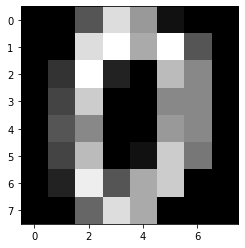

1


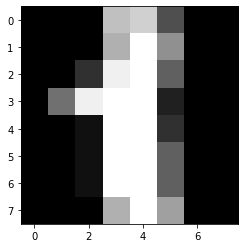

2


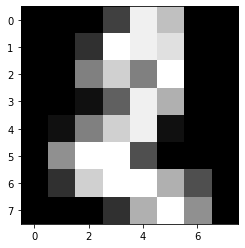

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
X,y = load_digits(n_class=10, return_X_y=True)
X = X.reshape((-1,8,8))
for i in range(3):
    print(y[i])
    plt.imshow(X[i],"gray")
    plt.show()

標準化/正規化ももちろん必須なので、してあげましょう。

モノクロ画像なので、チャンネル側がありませんが、reshapeして、チャンネル方向に拡張してください。

In [74]:
X = X / X.max()
X = X.reshape(-1, 1, 8, 8)
X.shape, y.shape

((1797, 1, 8, 8), (1797,))

訓練データとテストデータに分ける

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [76]:
parameters = {'output_channels':[2, 2],
              'filter_sizes':[(3, 3), (3,3)],
              'stride_sizes':[(1, 1), (1, 1)],
              'padding':['SAME', 'VALID'],
              'pooling':[None, None],
              'pooling_sizes':[None, None],
              'conv_activation':'relu',
              'conv_initialize':'he',
              'conv_optimize':'adagrad',
              'conv_lr':10e-3,
              'hidden_layer_sizes':[400, 200],
              'fc_activation':'relu',
              'fc_initialize':'he',
              'fc_optimize':'adagrad',
              'fc_lr':10e-3,
              'verbose':False,
              'random_state':0,
              'epoch':20,
              'batch_size':20}
cnn2d = Scratch2dCNNClassifier(**parameters)
cnn2d.fit(X_train, y_train, X_test, y_test)

100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Accuracy_score : 0.9133333333333333


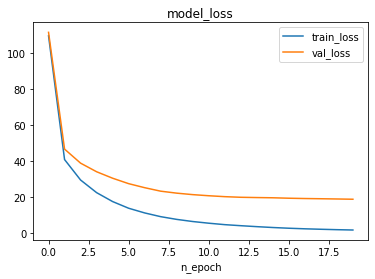

In [77]:
acc_score(X_test, y_test, cnn2d)
loss_plot(cnn2d)

### 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

![image](https://t.gyazo.com/teams/diveintocode/83358987a273743a589b9388dfdf59ac.png)

※上記論文から引用

サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。

1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数

In [78]:
# MNISTデータ　ロード
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# input_channelsを追加
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [79]:
"""
parameters = {'output_channels':[6, 16],
              'filter_sizes':[(5, 5), (5, 5)],
              'stride_sizes':[(1, 1), (1, 1)],
              'padding':['SAME', 'SAME'],
              'pooling':['max', 'max'],
              'pooling_sizes':[(3, 3), (3, 3)],
              'conv_activation':'relu',
              'conv_initialize':'he',
              'conv_optimize':'adagrad',
              'conv_lr':10e-3,
              'hidden_layer_sizes':[120, 84],
              'fc_activation':'relu',
              'fc_initialize':'he',
              'fc_optimize':'adagrad',
              'fc_lr':10e-3,
              'verbose':False,
              'random_state':0,
              'epoch':20,
              'batch_size':1000}
lanet = Scratch2dCNNClassifier(**parameters)
lanet.fit(X_train, y_train, X_test, y_test)
# scratchした学習器を保存
import pickle
with open('Scratch_CNN_LeNet_clf_Sprint12', 'wb') as f:
    pickle.dump(lanet, f)
"""

"\nparameters = {'output_channels':[6, 16],\n              'filter_sizes':[(5, 5), (5, 5)],\n              'stride_sizes':[(1, 1), (1, 1)],\n              'padding':['SAME', 'SAME'],\n              'pooling':['max', 'max'],\n              'pooling_sizes':[(3, 3), (3, 3)],\n              'conv_activation':'relu',\n              'conv_initialize':'he',\n              'conv_optimize':'adagrad',\n              'conv_lr':10e-3,\n              'hidden_layer_sizes':[120, 84],\n              'fc_activation':'relu',\n              'fc_initialize':'he',\n              'fc_optimize':'adagrad',\n              'fc_lr':10e-3,\n              'verbose':False,\n              'random_state':0,\n              'epoch':20,\n              'batch_size':1000}\nlanet = Scratch2dCNNClassifier(**parameters)\nlanet.fit(X_train, y_train, X_test, y_test)\n# scratchした学習器を保存\nimport pickle\nwith open('Scratch_CNN_LeNet_clf_Sprint12', 'wb') as f:\n    pickle.dump(lanet, f)\n"

In [80]:
# 学習器を呼び出す
import pickle
with open('Scratch_CNN_LeNet_clf_Sprint12', 'rb') as f:
    saved_scratch_lanet = pickle.load(f)

Accuracy_score : 0.9477


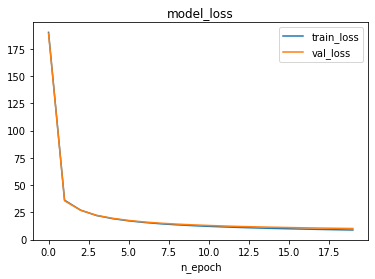

In [81]:
acc_score(X_test, y_test, saved_scratch_lanet)
loss_plot(saved_scratch_lanet)

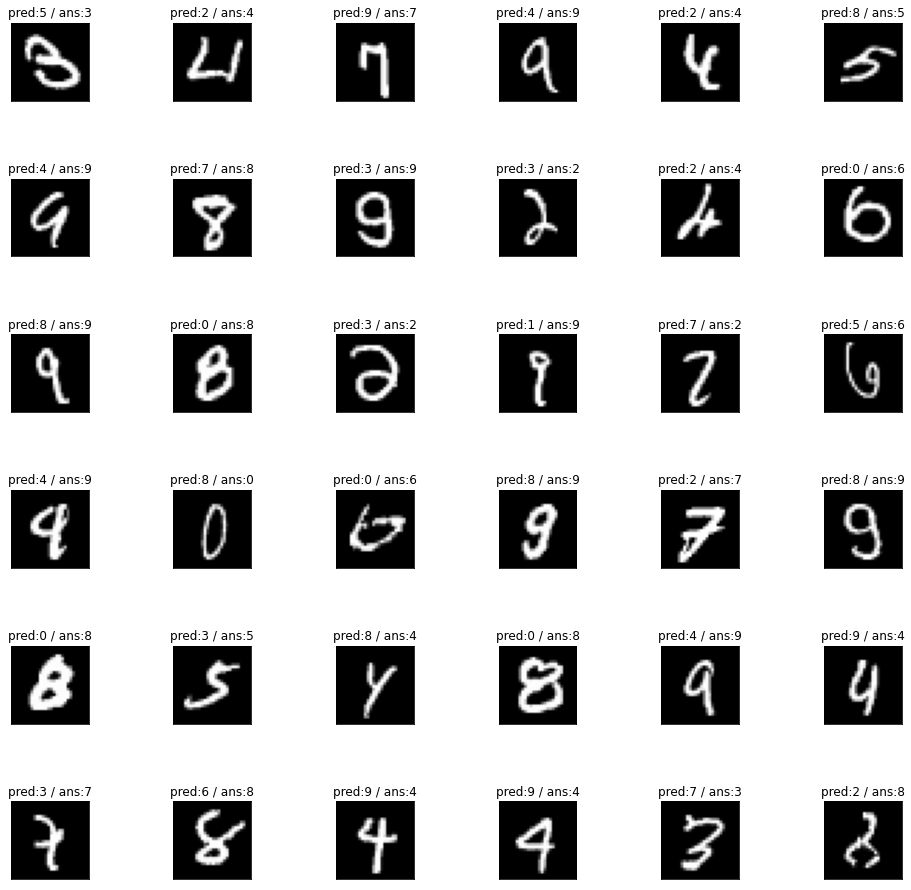

In [82]:
y_pred = saved_scratch_lanet.predict(X_test)
miss_class_imshow(y_pred, y_test, X_test, num=36, n_columns = 6)

### 【問題8】（アドバンス課題）有名な画像認識モデルの調査

CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。

どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

*《参考》*

[Applications - Keras Documentation](https://keras.io/ja/applications/)

*以下記事に多くのフレームワークが紹介されている*
- [ILSVRC2017_overview](http://image-net.org/challenges/talks_2017/ILSVRC2017_overview.pdf)

- [畳み込みニューラルネットワークの最新研究動向 (〜2017)](https://qiita.com/yu4u/items/7e93c454c9410c4b5427)

- [畳み込みニューラルネットワークの高精度化と高速化](https://www.slideshare.net/ren4yu/ss-145689425)

![image](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F139809%2F49368c48-fcda-f2db-47d6-963bdf993bcf.png?ixlib=rb-1.2.2&auto=format&gif-q=60&q=75&w=1400&fit=max&s=8ae0087a02077c8eb9d1733e13f16b92)

### 【問題9】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

In [83]:
# 畳み込み層
input_h, input_w, input_channels = 144, 144, 3
F_h, F_w, output_channels = 3, 3, 6
stride_h, stride_w = 1, 1
padding_h, padding_w = 0, 0 

In [84]:
output_h = (input_h + 2*padding_h - F_h) // stride_h + 1
output_w = (input_w + 2*padding_w - F_w) // stride_w + 1
output_size = output_h * output_w * output_channels
print('出力サイズ : {}'.format(output_size))

出力サイズ : 120984


In [85]:
parameters = input_channels * F_h * F_w * output_channels + output_channels
print('パラメーター数 : {}'.format(parameters))

パラメーター数 : 168


2.
- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

In [86]:
# 畳み込み層
input_h, input_w, input_channels = 60, 60, 24
F_h, F_w, output_channels = 3, 3, 48
stride_h, stride_w = 1, 1
padding_h, padding_w = 0, 0 

In [87]:
output_h = (input_h + 2*padding_h - F_h) // stride_h + 1
output_w = (input_w + 2*padding_w - F_w) // stride_w + 1
output_size = output_h * output_w * output_channels
print('出力サイズ : {}'.format(output_size))

出力サイズ : 161472


In [88]:
parameters = input_channels * F_h * F_w * output_channels + output_channels
print('パラメーター数 : {}'.format(parameters))

パラメーター数 : 10416


3.
- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

In [89]:
# 畳み込み層
input_h, input_w, input_channels = 20, 20, 10
F_h, F_w, output_channels = 3, 3, 20
stride_h, stride_w = 2, 2
padding_h, padding_w = 0, 0 

In [90]:
output_h = (input_h + 2*padding_h - F_h) // stride_h + 1
output_w = (input_w + 2*padding_w - F_w) // stride_w + 1
output_size = output_h * output_w * output_channels
print('出力サイズ : {}'.format(output_size))

出力サイズ : 1620


In [91]:
parameters = input_channels * F_h * F_w * output_channels + output_channels
print('パラメーター数 : {}'.format(parameters))

パラメーター数 : 1820


### 【問題10】（アドバンス課題）フィルタサイズに関する調査

畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
    - 5×5のフィルタと3×3のフィルタを２回通す場合では、出力されるサイズは同じであるが、パラメーター数は25:18であり、小さいフィルタを複数通した方が計算の効率化につながる

- 高さや幅方向を持たない1×1のフィルタの効果
    - 前の層のチャンネルより少ないチャンネルで1×1のフィルタを通すことにより、パラメーター数を削減できるので、計算能力が低い環境等でもモデルを動かせるようになる

- その他
    - フィルタは周辺ピクセルとの関係性を調べる調べるために用いられる。フィルタが偶数だと中心ピクセルが定まらなくなってしまうため、基本的にはいつも奇数である